In [2]:
import os
#os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt


from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap 
import jax.numpy as jnp
import equinox as eqx

import cmcrameri.cm as cmc

In [3]:
# --- Mesh generation (reuse from linear example) ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

In this tutorial, we will solve a nonlinear elasticity problem using the FEM solver. We consider a Neo-Hookean material model for which the strain energy density is given by:

$$
W = \frac{1}{2} \mu (I_1 - 3) + \frac{1}{2} \lambda \log^2(J)
$$

where $\mu$ and $\lambda$ are the Lame constants, $I_1$ is the first invariant of the right Cauchy-Green deformation tensor, and $J$ is the determinant of the deformation gradient.

The stress is given by:

$$
\sigma = \frac{\partial W}{\partial C} = \mu (C - I) + \lambda \log(J) \frac{C}{J}
$$

where $C$ is the right Cauchy-Green deformation tensor.

The deformation gradient is given by:

$$
F = \frac{\partial x}{\partial X}
$$

Which is given by:

$$
F = \nabla u + \boldsymbol{I}

$$



In [4]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float] 
    lmbda: eqx.AbstractVar[float]

In [27]:
# ------------- Neo-Hookean Material Model -------------------
def neo_hookean_energy(F, mu, lmbda):
    J = jnp.linalg.det(F)
    C = F.T @ F
    I1 = jnp.trace(C)
    energy = 0.5 * mu * (I1 - 2) - mu * jnp.log(J) + 0.5 * lmbda * (jnp.log(J)) ** 2
    return energy

@auto_vmap(grad_u=2)
def compute_deformation_gradient(grad_u):
    return grad_u + jnp.eye(2)

@auto_vmap(u_grad=2, mu=0, lmbda=0)
def compute_energy(u_grad, mu, lmbda):
    F = compute_deformation_gradient(u_grad)
    return neo_hookean_energy(F, mu, lmbda)


In [28]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = compute_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ


tri3 = get_element("tri3")
fem = ElasticityOperator(element=tri3, mu=1.0, lmbda=1.0)

In [29]:
# Create mesh
nodes, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = nodes.shape[0]


n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes


In [30]:
def total_energy(u_flat, coords, elements, fem):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    return jnp.sum(fem.integrate(u_cell, x_cell))



# creating functions to compute the gradient and 
# Hessian of the total energy using jax
residual = jax.grad(total_energy)
hessian = jax.jacfwd(residual)





# ------------- Initial Setup -------------------
num_nodes = nodes.shape[0]
u0 = jnp.zeros((num_nodes, 2))
u_flat = u0.flatten()

# Apply rightward displacement at nodes 1 and 3 (right side)
fixed_nodes = [0, 2]  # Left side fixed (x displacement)
loaded_nodes = [1, 3]  # Right side prescribed displacement
fixed_dofs = jnp.array([0, 4, 2, 6])  # x of nodes 0,2 and y of nodes 0,2

# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(nodes[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(nodes[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)



u_target = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.4)
#u_target = u0.at[loaded_nodes, 0].set(0.1)  # 0.2 rightward displacement
u_target_flat = u_target.flatten()

all_dofs = jnp.arange(u_flat.size)
free_dofs = jnp.setdiff1d(all_dofs, fixed_dofs)


To solve the nonlinear elasticity problem, we use the Newton-Raphson method. The residual is given by:

$$
r = \frac{\partial W}{\partial u} - f_{ext}
$$

where $f_{ext}$ is the external force.

The Hessian is given by:

$$
H = \frac{\partial^2 W}{\partial u^2}
$$

The Newton-Raphson update is given by:

$$
u_{n+1} = u_n -H^{-1} r
$$

For a load increment, the inner algorithm is implemented as follows:

1. Compute the residual $r$ at the current solution $u_n^{k}$
2. Compute the Hessian $H$ at the current solution $u_n^{k}$
3. Solve the linear system $H \delta u = -r$
4. Update the solution $u_{n}^{k+1} = u_{n}^{k} + \delta u$

5. Repeat steps 1-4 until the residual is small enough.

The outer algorithm is implemented as follows:

1. Compute the load increment $\Delta u$
2. Update the solution $u_{n+1} = u_n + \Delta u$
3. Repeat steps 1-2 until the load is applied.



In [31]:
# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fem,
    nodes,
    elements,
    u_flat,
    fixed_dofs,
    u_target_flat,
    n_steps=10,
    tol=1e-8,
    max_iter=20,
):
    all_dofs = jnp.arange(u_flat.size)
    free_dofs = jnp.setdiff1d(all_dofs, fixed_dofs)

    du_total = u_target_flat / n_steps
    u = u_flat.copy()

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])
        for i in range(max_iter):
            res = residual(u, nodes, elements, fem)
            H = hessian(u, nodes, elements, fem)
            res_r = res[free_dofs]

            H_rr = H[jnp.ix_(free_dofs, free_dofs)]

            delta_u = -jnp.linalg.solve(H_rr, res_r)
            u = u.at[free_dofs].add(delta_u)

            norm_res = jnp.linalg.norm(res_r)
            #print(f"  Residual: {norm_res:.2e}")
            if norm_res < tol:
                print(f"  Converged in {i+1} iterations with residual {norm_res:.2e}")
                break
        else:
            print("  Did not converge!")
    return u


In [32]:
u_full = newton_solver(
    fem, nodes, elements, u_flat, fixed_dofs, u_target_flat, n_steps=50
)


Step 1/50
  Converged in 4 iterations with residual 7.35e-11
Step 2/50
  Converged in 4 iterations with residual 6.58e-11
Step 3/50
  Converged in 4 iterations with residual 5.89e-11
Step 4/50
  Converged in 4 iterations with residual 5.27e-11
Step 5/50
  Converged in 4 iterations with residual 4.72e-11
Step 6/50
  Converged in 4 iterations with residual 4.23e-11
Step 7/50
  Converged in 4 iterations with residual 3.79e-11
Step 8/50
  Converged in 4 iterations with residual 3.40e-11
Step 9/50
  Converged in 4 iterations with residual 3.05e-11
Step 10/50
  Converged in 4 iterations with residual 2.74e-11
Step 11/50
  Converged in 4 iterations with residual 2.46e-11
Step 12/50
  Converged in 4 iterations with residual 2.21e-11
Step 13/50
  Converged in 4 iterations with residual 1.99e-11
Step 14/50
  Converged in 4 iterations with residual 1.79e-11
Step 15/50
  Converged in 4 iterations with residual 1.61e-11
Step 16/50
  Converged in 4 iterations with residual 1.45e-11
Step 17/50
  Conv

In [44]:
# we use automatic differentiation to compute the stress from the energy
compute_stress = jax.jacrev(neo_hookean_energy)

@auto_vmap(F=2, mu=0, lmbda=0)
def compute_stresses(F, mu, lmbda):
    return compute_stress(F, mu, lmbda)

@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)



In [45]:
grad_us = fem.gradient(u_full.reshape(-1, n_dofs_per_node)[elements], nodes[elements])
deformation_gradients = compute_deformation_gradient(grad_us)
stresses = compute_stresses(deformation_gradients, fem.mu, fem.lmbda)
stress_vm = von_mises_stress(stresses)

In [46]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()


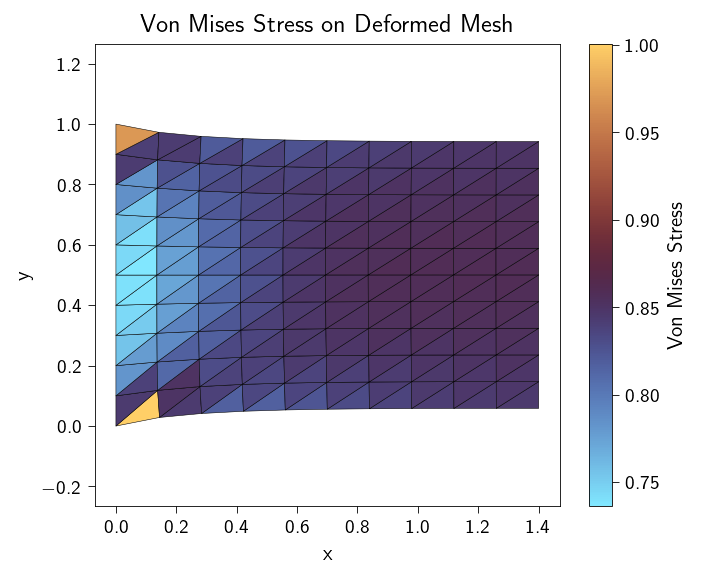

In [47]:
# ------------- Postprocessing -------------------
u = u_full.reshape(-1, n_dofs_per_node)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(nodes, u, elements, stress_vm.flatten())